In [1]:
import camb
import numpy as np
import scipy.integrate as si
from camb import get_matter_power_interpolator
from colossus.cosmology import cosmology as col_cosmology
from colossus.lss import bias, mass_function



import limpy.cosmos as cosmos


In [2]:
import limpy.lines as ll

In [3]:
!pip show limpy

Name: limpy
Version: 2.0
Summary: Line Intensity Mapping code in PYthon
Home-page: 
Author: Anirban Roy
Author-email: anirbanroy.personal@gmail.com
License: 
Location: /Users/anirbanroy/anaconda3/envs/limpyv2/lib/python3.8/site-packages/limpy-2.0-py3.8.egg
Requires: astropy, camb, colossus
Required-by: 


In [4]:
ll.mhalo_to_lline(1e13, 3)

array([8.95062513e+08])

In [5]:
halo_file ="../limpy/data/" + 'halos_L205_z7.00.npz'

In [98]:
# cross CII_280 * CO54 (90)
z = 7.00  # redshift of catalog
line_name = "CII158" # line name that you want to paint

model_name="Fonseca16"  # line luminosity model name
sfr_model="Behroozi19" # sfr model name 
mmin=1e11              # minimum mass of the halos
small_h = 0.68         # value of Hubble parameter. H0 = 100 * small_h
halocat_file_type="input_cat" # 
ngrid= 256             # numer of grid points along the all three exes
boxsize = 205          # Length of the box 


In [99]:
ls=ll.lim_sims(halo_file, 2, boxsize_x=boxsize, boxsize_y=boxsize, 
               boxsize_z=boxsize, nu_obs=220, dnu_obs=None, model_name = "Silva15-m1",
               theta_fwhm=None, line_params={"use_scatter": False})


ls1=ll.lim_sims(halo_file, 2, boxsize_x=boxsize, boxsize_y=boxsize, 
               boxsize_z=boxsize, nu_obs=220, dnu_obs=None, model_name = "Silva15-m1",
               theta_fwhm=None, line_params={"use_scatter": True})

In [100]:
grid=  ls.make_intensity_grid()
grid1=  ls1.make_intensity_grid()

In [101]:
from powerbox import get_power

pk, k = get_power(grid, boxsize)

pk1, k1 = get_power(grid1, boxsize)

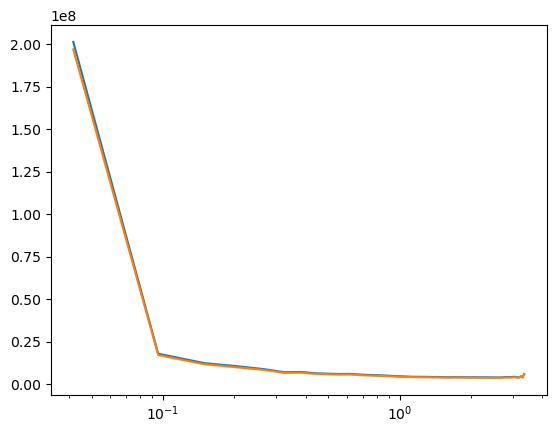

In [102]:
import matplotlib.pyplot as plt

plt.plot(k1, pk1)
plt.plot(k, pk)

#plt.yscale("log")

plt.xscale("log")

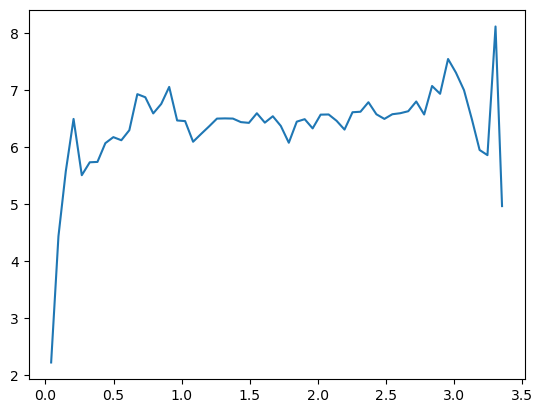

In [103]:
plt.plot(k, (pk1-pk)*100/pk)

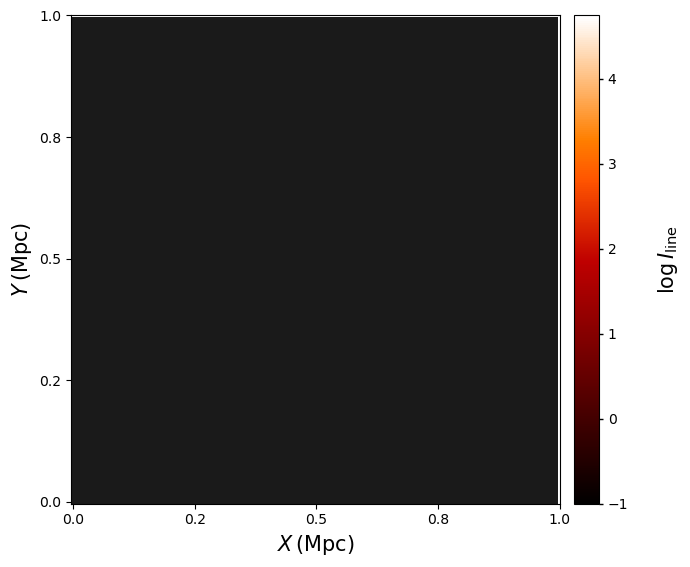

In [24]:
from limpy.plotter import plotter

plotter.plot_beam_convolution(
        (grid1[:,:,0]),
        128,
        1,
        5.8, plot_scale="log")

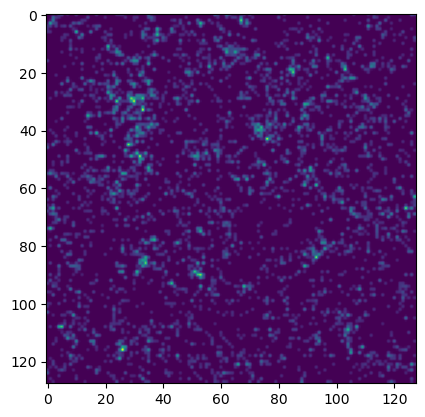

In [90]:
import matplotlib.pyplot as plt

plt.imshow(grid1, vmin =1e1, vmax=1e3)

In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  9 11:57:35 2020

@author: anirbanroy
"""
import imp

import numpy as np
from scipy.integrate import simps

import limpy.cosmos as cosmos
import limpy.inputs as inp

imp.reload(cosmos)


from astropy.convolution import Gaussian2DKernel, convolve


# Name of all lines
line_list = [
    "CI371",
    "CI610",
    "CII158",
    "CO10",
    "CO21",
    "CO32",
    "CO43",
    "CO54",
    "CO65",
    "CO76",
    "CO87",
    "CO98",
    "CO109",
    "CO1110",
    "CO1211",
    "CO1312",
    "NII122",
    "NII205",
    "NIII57",
    "OI63",
    "OI145",
    "OIII52",
    "OIII88",
]


def model_avail(line_name="CII158", do_print=False):
    """
    Gives the available model names for a particularl line name.

    parameters
    ----------
    line_name: str
            name of the line to calculate intensity and other quantities.

    Returns
    -------
    sfr_model: str
            Available star formation models.

    model_name: str
            Available model names that converts the star formation rate to
            line luminosity or halo mass to line luminosity.
    """

    if line_name not in line_list:
        raise ValueError("Line name is not known. Check available lines.")

    sfr_models = ["Behroozi19", "Tng300", "Tng100", "Silva15", "Fonseca16"]

    if line_name == "CII158":
        model_names = [
            "Visbal10",
            "Silva15-m1",
            "Silva15-m2",
            "Silva15-m3",
            "Silva15-m4",
            "Fonseca16",
            "Lagache18",
            "Schaerer20",
            "Alma_scalling",
        ]

    if line_name == "CO10":
        model_names = ["Visbal10", "Kamenetzky15", "Alma_scalling"]

    if (
        line_name == "CO21"
        or line_name == "CO32"
        or line_name == "CO43"
        or line_name == "CO54"
        or line_name == "CO65"
        or line_name == "CO76"
        or line_name == "CO87"
        or line_name == "C98"
        or line_name == "CO109"
        or line_name == "1110"
        or line_name == "CO1211"
        or line_name == "CO1312"
    ):

        model_names = ["Visbal10", "Kamenetzky15", "Alma_scalling"]

    if line_name == "NII122":
        model_names = ["Visbal10"]

    if line_name == "NII205":
        model_names = ["Visbal10"]

    if line_name == "NIII57":
        model_names = ["Visbal10"]

    if line_name == "OI63":
        model_names = ["Visbal10"]

    if line_name == "OI145":
        model_names = ["Visbal10"]

    if line_name == "OIII52":
        model_names = ["Visbal10"]

    if line_name == "OIII88":
        model_names = [
            "Visbal10",
            "Delooze14",
            "Gong17",
            "Fonseca16",
            "Kannan22",
            "Alma_scalling",
        ]
    
    if do_print:
        print("The models available for %s lines\n" % (line_name))
        print("\n The star formation models are :", (sfr_models))
        print("\n The luminosity models are :", (model_names))

    return sfr_models, model_names


def line_scattered_params_alma(line_name="CII158"):
    if line_name == "CII158":
        a_off = inp.a_off_CII_158
        a_std = inp.a_std_CII_158
        b_off = inp.b_off_CII_158
        b_std = inp.b_std_CII_158

    if line_name == "OIII88":
        a_off = inp.a_off_OIII_88
        a_std = inp.a_std_OIII_88
        b_off = inp.b_off_OIII_88
        b_std = inp.b_std_OIII_88

    if line_name == "CO10":
        a_off = inp.a_off_CO_1_0
        a_std = inp.a_std_CO_1_0
        b_off = inp.b_off_CO_1_0
        b_std = inp.b_std_CO_1_0
    if line_name == "CO21":
        a_off = inp.a_off_CO_2_1
        a_std = inp.a_std_CO_2_1
        b_off = inp.b_off_CO_2_1
        b_std = inp.b_std_CO_2_1
    if line_name == "CO32":
        a_off = inp.a_off_CO_3_2
        a_std = inp.a_std_CO_3_2
        b_off = inp.b_off_CO_3_2
        b_std = inp.b_std_CO_3_2
    if line_name == "CO43":
        a_off = inp.a_off_CO_4_3
        a_std = inp.a_std_CO_4_3
        b_off = inp.b_off_CO_4_3
        b_std = inp.b_std_CO_4_3
    if line_name == "CO54":
        a_off = inp.a_off_CO_5_4
        a_std = inp.a_std_CO_5_4
        b_off = inp.b_off_CO_5_4
        b_std = inp.b_std_CO_5_4
    if line_name == "CO65":
        a_off = inp.a_off_CO_6_5
        a_std = inp.a_std_CO_6_5
        b_off = inp.b_off_CO_6_5
        b_std = inp.b_std_CO_6_5
    if line_name == "CO76":
        a_off = inp.a_off_CO_7_6
        a_std = inp.a_std_CO_7_6
        b_off = inp.b_off_CO_7_6
        b_std = inp.b_std_CO_7_6
    if line_name == "CO87":
        a_off = inp.a_off_CO_8_7
        a_std = inp.a_std_CO_8_7
        b_off = inp.b_off_CO_8_7
        b_std = inp.b_std_CO_8_7
    if line_name == "CO98":
        a_off = inp.a_off_CO_9_8
        a_std = inp.a_std_CO_9_8
        b_off = inp.b_off_CO_9_8
        b_std = inp.b_std_CO_9_8
    if line_name == "CO109":
        a_off = inp.a_off_CO_10_9
        a_std = inp.a_std_CO_10_9
        b_off = inp.b_off_CO_10_9
        b_std = inp.b_std_CO_10_9
    if line_name == "CO1110":
        a_off = inp.a_off_CO_11_10
        a_std = inp.a_std_CO_11_10
        b_off = inp.b_off_CO_11_10
        b_std = inp.b_std_CO_11_10
    if line_name == "CO1211":
        a_off = inp.a_off_CO_12_11
        a_std = inp.a_std_CO_12_11
        b_off = inp.b_off_CO_12_11
        b_std = inp.b_std_CO_12_11
    if line_name == "CO1312":
        a_off = inp.a_off_CO_13_12
        a_std = inp.a_std_CO_13_12
        b_off = inp.b_off_CO_13_12
        b_std = inp.b_std_CO_13_12

    return a_off, a_std, b_off, b_std


def lambda_line(line_name="CI371"):
    """
    Wavelngth of the line.

    parameters
    ----------
    line_name: str
            name of the line to calculate intensity and other quantities.

    Returns
    -------
    lambda_line: float
            rest-frame wavelength of the line.
    """

    if line_name[0:2] == "CO":
        line_name_len = len(line_name)
        if line_name_len == 4:
            J_ladder = int(line_name[2])
        if line_name_len == 5 or line_name_len == 6:
            J_ladder = int(line_name[2:4])

        lambda_CO10 = 2610

        lambda_line = lambda_CO10 / J_ladder

    else:
        num = ""
        for i in line_name:
            if i.isdigit():
                num = num + i
        lambda_line = int(num)

    return lambda_line


def lambda_to_nu(lambda_line):
    """
    Converts wavelength to frequency

    parameters
    ----------
    lambda_line
               wavelength of lines in micro-meter.

    Returns
    -------
    frequency in GHz.

    """

    nu = inp.c_in_m / lambda_line / 1e-6 / 1e9  # in GHz
    return nu


def nu_rest(line_name="CII158"):
    """
    Rest frame frequency of lines.
    """
    wavelength = lambda_line(line_name=line_name)
    nu = lambda_to_nu(wavelength)
    return nu



def freq_to_lambda(nu):
    "frequency to wavelength converter."
    wav = c_in_mpc / nu
    return wav  # in mpc/h unit




def volume_box(boxsize):
    """
    Volume of the simulation box.
    
    Parameters
    ----------
    boxsize: float
        the length of the box in MPc/h
    
    Returns
    -------
        volume in (Mpc/h)^3
    """
    
    return boxsize**3


def volume_cell(boxsize, ngrid):
    """
    Volume of the cells (for a cube).
    
    Parameters
    ----------
    boxsize: float
        the length of the box in MPc/h
        
    ngrid: int
        Number of grids along the one direction of box.
    
    Returns
    -------
        volume in (Mpc/h)^3
    """
    
    clen = boxsize / ngrid  # length of a cell
    return clen**3  # in (Mpc/h)**3


def convert_beam_unit_to_radian(theta_beam, beam_unit):
    """
    Converts the beam in radian
    
    Parameters
    ----------
    theta_beam: float
        FWHM of the beam
        
    beam_unit: str
        The unit of angle, either in arcmin, degree or radian.
    
    Returns
    -------
    boxsize: float
        The comoving boxsize in (Mpc/h)
    """
    
    if beam_unit == "arcmin" or beam_unit == "min" or beam_unit == "minute":
        theta_beam *= (1.0 / 60) * (np.pi / 180)
    if beam_unit == "arcsec" or beam_unit == "sec" or beam_unit == "second":
        theta_beam *= (1.0 / 3600) * (np.pi / 180)
    if beam_unit == "degree" or beam_unit == "deg":
        theta_beam *= np.pi / 180
    if beam_unit == "radian" or beam_unit == "rad":
        theta_beam = theta_beam

    return theta_beam


def sigma_beam(theta_beam, beam_unit="arcmin"):
    """
    Parameters
    ----------
    theta_beam: float
        FWHM of the beam
        
    beam_unit: str
        The unit of angle, either in arcmin, degree or radian.
    
    Returns
    -------
    the standard deviation of the beam.
    """
    
    theta = convert_beam_unit_to_radian(theta_beam, beam_unit=beam_unit)
    return theta / np.sqrt(8 * np.log(2))


def Omega_beam(theta_beam, beam_unit="arcmin"):
    """
    Parameters
    ----------
    theta_beam: float
        FWHM of the beam
        
    beam_unit: str
        The unit of angle, either in arcmin, degree or radian.
    
    Returns
    -------
    the standard deviation of the beam.
    """
    
    theta_rad = convert_beam_unit_to_radian(theta_beam, beam_unit=beam_unit)
    return np.pi * theta_rad**2 / 4 * np.log(2)



def t_pix(theta_beam, tobs_total, Ndet_eff, S_area, beam_unit="arcmin"):
    """
    Time per pixel.

    theta_min: the beam size in arc-min.
    tobs_total: total observing time.
    Ndet_eff: Effective number of detectors, for CCATp, Ndet_eff~20.
    S_area: Survey area in degree^2.

    return: t_pix in second.

    """
    omega_beam = Omega_beam(theta_beam, beam_unit=beam_unit)
    S_area_rad = S_area * (inp.degree_to_radian) ** 2

    tobs_total *= 3600  # hours to seconds
    res = tobs_total * Ndet_eff * omega_beam / (S_area_rad)
    return res


def nu_obs_to_z(nu_obs, line_name="CII158"):
    """
    This function evaluates the redshift of a particular line emission
    corresponding to the observed frequency.

    return: redshift of line emission.
    """

    global nu_rest_line

    nu_rest_line = nu_rest(line_name=line_name)

    if nu_obs >= nu_rest_line:
        z = 0

    else:
        z = (nu_rest_line / nu_obs) - 1
    return z




def get_lines_same_frequency(line_list, nu_obs=220, dnu_obs=40, zlim=15):
    global z_em
    list_len = len(line_list)
    z_em =  np.zeros(list_len)
    dz_em = np.zeros(list_len)
    
    for i in range(list_len):
        nu_rest = nu_rest(line_name=line_list[i]) 
        z_em[i] = (nu_rest / nu_obs) - 1
        dz_em[i] = nu_rest * dnu_obs / (nu_obs * (nu_obs + dnu_obs))
        
        
            
    mask = (z_em>0) & (z_em<zlim)
    z_em= z_em[mask]
    dz_em= dz_em[mask]
    line_names= np.array(line_list)[mask]   
    
    return np.round(z_em, 2), dz_em,  line_names



def sigma_noise(theta_min, NEI, beam_unit="arcmin"):
    """
    noise per pixel.
    Eq 22 and 23 of https://arxiv.org/pdf/1802.04804.pdf.
    """

    # omegab=Omega_beam(theta_min, beam_unit=beam_unit)
    return NEI  # * 1e-9/omegab


def P_noise(z, theta_min, delta_nu, NEI, tobs_total, Nspec_eff, S_a):
    """
    White noise of an experiment.
    z: redshift
    theta_min: beam size in arc-min
    delta_nu: frequency resolution in GHz.
    NEI: noise equivalence impedence.
    tobs_total: total observing time in hours.
    Nspec_eff: effective number of detectors.
    S_a: Survey area in degree^2.
    """

    Pn = (
        V_pix(z, theta_min, delta_nu)
        * sigma_noise(theta_min, NEI) ** 2
        / (t_pix(theta_min, tobs_total, Nspec_eff, S_a))
    )
    return Pn


def P_noise_ccatp(nu=220):
    if nu == 220:
        res = 2.6e9

    elif nu == 280:
        res = 4.9e9

    elif nu == 350:
        res = 3.9e10

    elif nu == 410:
        res = 1.2e11

    return res


def N_modes(k, z, delta_k, Vs):
    res = 2 * np.pi * k**2 * delta_k * Vs / (2 * np.pi) ** 3
    return res


def V_survey(z, dnu_obs=2.8, area= 16, line_name = "CII158"):
    "Survey field for CII lines" # given by Gong et al. 2012
    
    lambda_line = lambda_line(line_name=line_name)

    res= 3.7e7 * np.sqrt((1+z)/8)* (area/ 16) * (dnu_obs/ 20) * (lambda_line/158)

    return res


def slice(datacube, ngrid, nproj, option="C"):
    """
    Produces a slice from a 3D data cube for plotting. `option' controls
    whether data cube has C or Fortran ordering.

    """
    datacube = datacube.reshape(ngrid**3)

    iarr = np.zeros(ngrid * ngrid)
    jarr = np.zeros(ngrid * ngrid)
    valarr = np.zeros(ngrid * ngrid)

    counter = 0
    for i in range(ngrid):
        for j in range(ngrid):
            iarr[counter] = i
            jarr[counter] = j
            valarr[counter] = 0.0
            for k in range(nproj):
                if option == "F":
                    valarr[counter] += datacube[i + ngrid * (j + ngrid * k)]
                elif option == "C":
                    valarr[counter] += datacube[k + ngrid * (j + ngrid * i)]
            counter += 1

    return iarr, jarr, valarr


def freq_2D(boxsize, ngrid):
    kf = 2.0 * np.pi / boxsize
    kn = np.pi / (boxsize / ngrid)

    return kf, kn


def read_grid(fname, ngrid=None):
    """
    Read a 3D grid from a dat file.
    """

    with open(fname, "rb") as f:
        grid = np.fromfile(f, dtype="f", count=-1)

    if ngrid is not None:
        return grid.reshape(ngrid, ngrid, ngrid)
    else:
        return grid


def slice_2d(datacube, ngrid, nproj=None, operation="sum", axis=2):
    """
    Produces a slice from a 3D data cube for power spectra calculation.

    nproj: number of cells to project.

    operation suggestion either to "sum" or "mean" over projection cells.

    axis: The axis along which projection is done. It can be 1, 2 or 3.
    """

    ndim = np.ndim(datacube)
    # print("The dimension of data", ndim)

    if nproj == None:
        data_cut = datacube  # Project all cells along the axis

    else:
        if ndim == 1:
            data_cut = datacube.reshape(ngrid, ngrid, ngrid)[
                :, :, :nproj
            ]  # Project first nproj cells along the axis

        elif ndim == 3:
            data_cut = datacube[
                :, :, :nproj
            ]  # Project first nproj cells along the axis

        else:
            raise ValueError(
                "Provide the data either in 1D or 3D data cube (in case of projection)"
            )

    if operation == "sum":
        # Project number of cells along the third axis.
        data_2d = data_cut.sum(axis=axis)
    if operation == "mean":
        data_2d = data_cut.mean(axis=axis)

    return data_2d


def make_slice_2d(datacube, ngrid, nproj, operation="sum", axis=2):
    """
    Produces a slice from a 3D data cube for power spectra calculation.

    nproj: number of cells to project.

    operation suggestion either to "sum" or "mean" over projection cells.

    axis: The axis along which projection is done. It can be 1, 2 or 3.
    """

    ndim = np.ndim(datacube)
    # print("The dimension of data", ndim)

    if ndim == 1:
        data_cut = datacube.reshape(ngrid, ngrid, ngrid)[:, :, :nproj]

    elif ndim == 3:
        data_cut = datacube[:, :, :nproj]

    else:
        raise ValueError(
            "Provide the data either in 1D or 3D data cube (in case of projection)"
        )

    if operation == "sum":
        # Project number of cells along the third axis.
        data_2d = data_cut.sum(axis=axis)
    if operation == "mean":
        data_2d = data_cut.mean(axis=axis)

    return data_2d


def make_hlist_ascii_to_npz(hlist_path_ascii, filename=None):
    """
    Takes a hlist file in the form of Universemachine format and tranforms
    to a npz file with necessary quantities.
    coumn 0: scale factor
    coulumn 1: halo mass
    column 2: x co-ordinate of halos
    column 3: y co-ordinate of halos
    column 4: z co-ordinate of halos
    """

    # reads only scale factor, halomass,x,y and z from the ascii file used in Universe machine
    data = np.loadtxt(hlist_path_ascii)

    # save the file in npz format either in mentioned filename or in original ascii filename
    if filename:
        np.savez(filename, m=data[:, 0], x=data[:, 1], y=data[:, 2], z=data[:, 3])
    else:
        np.savez(
            hlist_path_ascii, m=data[:, 0], x=data[:, 1], y=data[:, 2], z=data[:, 3]
        )
    return


def make_halocat(halo_file, halocat_type="input_cat", mmin=None, boxsize=None):
    """
    reads the mass and co-ordinates of halos from a npz file.

    boxsize in Mpc unit according to 21cmfast convention.

    Input: halo file in npz format

    Returns: m and (x,y,z)
    """

    if halocat_type == "input_cat":
        fn = np.load(halo_file)
        if mmin == None:
            # halomass and x,y,z are read in the following format
            halomass, halo_x, halo_y, halo_z = fn["m"], fn["x"], fn["y"], fn["z"]

        else:
            halomass, halo_x, halo_y, halo_z = fn["m"], fn["x"], fn["y"], fn["z"]
            mass_cut = halomass >= mmin
            halomass = halomass[mass_cut]
            halo_x = halo_x[mass_cut]
            halo_y = halo_y[mass_cut]
            halo_z = halo_z[mass_cut]

            ind_sort = np.argsort(halomass)
            halomass = halomass[ind_sort]
            halo_x = halo_x[ind_sort]
            halo_y = halo_y[ind_sort]
            halo_z = halo_z[ind_sort]

    halo_cm = np.array([halo_x, halo_y, halo_z]).T

    del halo_x
    del halo_y
    del halo_z

    return halomass, halo_cm




def cic(x):
    dx, f = np.modf(x)
    return int(f), (1.0 - dx, dx)


def grid(posarr, weight, boxlength, ngrid, ndim=3):
    cell_size = boxlength / ngrid
    Vcell = cell_size**ndim

    n = ngrid
    gridarr = np.zeros(n**3)
    for i in range(weight.size):
        x = posarr[3 * i] / cell_size
        y = posarr[3 * i + 1] / cell_size
        z = posarr[3 * i + 2] / cell_size
        fx, cx = cic(x)
        fy, cy = cic(y)
        fz, cz = cic(z)
        for i1 in range(2):
            j1 = i1 + fx if i1 + fx < n else 0
            # print(j1)
            for i2 in range(2):
                j2 = i2 + fy if i2 + fy < n else 0
                for i3 in range(2):
                    j3 = i3 + fz if i3 + fz < n else 0
                    gridarr[j3 + n * (j2 + n * j1)] += (
                        cx[i1] * cy[i2] * cz[i3] * weight[i] / Vcell
                    )
    return gridarr


def grid_obj(posarr, weight, boxlength, ngrid, ndim=3):
    cell_size = boxlength / ngrid
    Vcell = cell_size**ndim

    n = ngrid
    gridarr = np.zeros(n**3)
    for i in range(weight.size):
        x = posarr[3 * i] / cell_size
        y = posarr[3 * i + 1] / cell_size
        z = posarr[3 * i + 2] / cell_size
        fx, cx = cic(x)
        fy, cy = cic(y)
        fz, cz = cic(z)
        for i1 in range(2):
            j1 = i1 + fx if i1 + fx < n else 0
            # print(j1)
            for i2 in range(2):
                j2 = i2 + fy if i2 + fy < n else 0
                for i3 in range(2):
                    j3 = i3 + fz if i3 + fz < n else 0
                    gridarr[j3 + n * (j2 + n * j1)] += (
                        cx[i1] * cy[i2] * cz[i3] * weight[i] / Vcell
                    )
    return gridarr


def grid_2d(posarr, weight, boxlength, ngrid, ndim=2):
    cell_size = boxlength / ngrid
    Vcell = cell_size**ndim

    n = ngrid
    gridarr = np.zeros(n**2)
    for i in range(weight.size):
        x = posarr[2 * i] / cell_size
        y = posarr[2 * i + 1] / cell_size
        fx, cx = cic(x)
        fy, cy = cic(y)
        for i1 in range(2):
            j1 = i1 + fx if i1 + fx < n else 0
            # print(j1)
            for i2 in range(2):
                j2 = i2 + fy if i2 + fy < n else 0
                gridarr[j2 + n * j1] += cx[i1] * cy[i2] * weight[i] / Vcell
    return gridarr


def make_grid(hloc, output_grid_dim="2D", weight=None, boxsize=None, ngrid=None):
    cellsize = boxsize / ngrid

    if output_grid_dim == "2D":
        grid = np.zeros([ngrid, ngrid])

        if np.isscalar(weight) == True:
            weight = weight * np.ones(len(hloc))

        for i in range(len(hloc)):
            hx = int(hloc[i][0] / cellsize)
            hy = int(hloc[i][1] / cellsize)

            grid[hx][hy] += weight[i]

            
    elif output_grid_dim == "3D":
        grid = np.zeros([ngrid, ngrid, ngrid])
        if np.isscalar(weight) == True:
            weight = weight * np.ones(len(hloc))

        for i in range(len(hloc)):
            hx = int(hloc[i][0] / cellsize)
            hy = int(hloc[i][1] / cellsize)
            hz = int(hloc[i][2] / cellsize)         
            grid[hx][hy][hz] += weight[i]

    return grid



def make_grid_new(hloc, output_grid_dim="2D", weight=None, boxsize=None, ngrid=None):
    cellsize = boxsize / ngrid

    if output_grid_dim == "2D":
        grid = np.zeros([ngrid, ngrid])

        if np.isscalar(weight) == True:
            weight = weight * np.ones(len(hloc))

        for i in range(len(hloc)):
            hx = int(hloc[i][0] / cellsize)
            hy = int(hloc[i][1] / cellsize)

            grid[hx][hy] += weight[i]

            

    elif output_grid_dim == "3D":
        grid = np.zeros([ngrid, ngrid, ngrid])
        if np.isscalar(weight) == True:
            weight = weight * np.ones(len(hloc))

        for i in range(len(hloc)):
            hx = int(hloc[i][0] / cellsize)
            hy = int(hloc[i][1] / cellsize)
            hz = int(hloc[i][2] / cellsize)

            grid[hx][hy][hz] += weight[i]


    return grid


def make_grid_rectangular(
    hloc,
    weight=None,
    ngrid_x=None,
    ngrid_y=None,
    ngrid_z=None,
    boxsize_x=None,
    boxsize_y=None,
    boxsize_z=None,
):

    if ngrid_x == None and ngrid_y == None and ngrid_z == None:
        print("Specify the grid numbers along x, y, z directions")

    if boxsize_x == None and boxsize_y == None and boxsize_z == None:
        print("Specify the box size in MPc along x, y, z directions")

    cellsize_x = boxsize_x / ngrid_x
    cellsize_y = boxsize_y / ngrid_y
    cellsize_z = boxsize_z / ngrid_z

    grid = np.zeros([ngrid_x, ngrid_y, ngrid_z])
    if np.isscalar(weight) == True:
        weight = weight * np.ones(len(hloc))

    for i in range(len(hloc)):
        hx = int(hloc[i][0] / cellsize_x)
        hy = int(hloc[i][1] / cellsize_y)
        hz = int(hloc[i][2] / cellsize_z)

        grid[hx][hy][hz] += weight[i]

    return grid


def make_grid_rectangular_object_number(
    hloc,
    weight=None,
    ngrid_x=None,
    ngrid_y=None,
    ngrid_z=None,
    boxsize_x=None,
    boxsize_y=None,
    boxsize_z=None,
):

    if ngrid_x == None and ngrid_y == None and ngrid_z == None:
        print("Specify the grid numbers along x, y, z directions")

    if boxsize_x == None and boxsize_y == None and boxsize_z == None:
        print("Specify the box size in MPc along x, y, z directions")

    cellsize_x = boxsize_x / ngrid_x
    cellsize_y = boxsize_y / ngrid_y
    cellsize_z = boxsize_z / ngrid_z

    grid = np.zeros([ngrid_x, ngrid_y, ngrid_z])

    if np.isscalar(weight) == True:
        weight = weight * np.ones(len(hloc))

    if weight is None:
        weight = np.ones(len(hloc))

    for i in range(len(hloc)):
        hx = int(hloc[i][0] / cellsize_x)
        hy = int(hloc[i][1] / cellsize_y)
        hz = int(hloc[i][2] / cellsize_z)
        grid[hx][hy][hz] += 1

    return grid


def update_params(params_old, params_to_update):
    for i in params_old:
        for j in params_to_update:
            if i == j:
                params_old[i] = params_to_update[j]
    return params_old


def make_grid_3D(hloc, weight=None, boxsize=None, ngrid=None):
    cellsize = boxsize / ngrid

    grid = np.zeros([ngrid, ngrid, ngrid])
    if np.isscalar(weight) == True:
        weight = weight * np.ones(len(hloc))

    for i in range(len(hloc)):
        hx = int(hloc[i][0] / cellsize)
        hy = int(hloc[i][1] / cellsize)
        hz = int(hloc[i][2] / cellsize)
        
        grid[hx][hy][hz] += weight[i]

    return grid



def get_noise_grid(pk_noise, 
                  boxsize_x=None,
                  boxsize_y=None,
                  boxsize_z=None,
                  ngrid_x=None,
                  ngrid_y=None, 
                  ngrid_z=None):

    # This function calculates a noise grid based using Gaussian approximation for a simulation box.

    x_ngrid= ngrid_x
    y_ngrid= ngrid_y
    z_ngrid= ngrid_z

    numbers_norm=np.random.normal(0.0, 1, x_ngrid * y_ngrid * z_ngrid)
    num_norm=numbers_norm.reshape( x_ngrid , y_ngrid , z_ngrid)

    Vol=(boxsize_x/ x_ngrid)  * (boxsize_y/ y_ngrid) * (boxsize_z/ z_ngrid)

    print("Calculating Fourier Transform to generate noise grid in Fourier space")
    f1=np.sqrt(pk_noise)*np.fft.fftn(num_norm)/np.sqrt(Vol)

    print("Calculating Inverse Fourier Transform to generate noise grid in Real space")
    f1_rp=np.fft.ifftn(f1)
    f2=np.real(f1_rp)
    
    return f2



def dk(k, pk):
    return k **3 * pk/2.0/np.pi**2


def make_grid_dnu_obs(grid,
                      boxsize_x,
                      boxsize_y,
                      boxsize_z,
                      ngrid_x,
                      ngrid_y,
                      ngrid_z,
                      nu_obs,
                      dnu_obs,
                      line_name,
                      theta_fwhm=None):
    """
    Generate a gridded cube of intensity fluctuations from a simulation box for a 
    given frequency resolution.
    
    Parameters
    ----------
    grid : array_like
        The 3D cube of intensity values in the simulation box. 
        Shape should be (ngrid_x, ngrid_y, ngrid_z).
    ngrid_x : int
        Number of grid cells in the x-direction.
    ngrid_y : int
        Number of grid cells in the y-direction.
    ngrid_z : int
        Number of grid cells in the z-direction.
    boxsize_x : float
        Size of the simulation box in the x-direction in Mpc/h.
    boxsize_y : float
        Size of the simulation box in the y-direction in Mpc/h.
    boxsize_z : float
        Size of the simulation box in the z-direction in Mpc/h.
    nu_obs : float
        Observed frequency of an experiment in GHz.
    dnu_obs : float
        frequncy resolution in GHz.
    line_name : str
        Name of the emission line.
    theta_fwhm : float, optional
        Full width at half maximum of the telescope beam in arcminutes.
        If not given, no beam convolution will be applied.
    
    Returns
    -------
    array_like
        The 3D cube of convolved intensity fluctuations. 
    """
    
    global zem, dz, dchi, d_ngrid 
    
    # Compute useful quantities
    zem, dz, dchi, d_ngrid = box_freq_to_quantities(nu_obs=nu_obs,
                                                       dnu_obs=dnu_obs,
                                                       boxsize=boxsize_z,
                                                       ngrid=ngrid_z,
                                                       line_name=line_name)
    
    Ngrid_new = int(ngrid_z/d_ngrid) if d_ngrid < ngrid_z else 1
    d_ngrid = min(d_ngrid, ngrid_z)
    
    if theta_fwhm is not None:
        convolved_grid = []
        theta = convert_beam_unit_to_radian(theta_fwhm, beam_unit= 'arcmin')
        
        for i in range(Ngrid_new):
            grid_start = i * d_ngrid
            grid_end = (i+1) * d_ngrid
            z_start = zem + (i* dz)
            print(grid_start, grid_end)
            
            beam_size = angle_to_comoving_size(z_start, theta)
            beam_std = beam_size / (np.sqrt(8 * np.log(2.0)))
            gauss_kernel = Gaussian2DKernel(beam_std)
            grid_quantity = np.mean(grid[:,:, grid_start: grid_end], axis =2)
            
            
            convolved_grid_cal = convolve(grid_quantity, gauss_kernel)
            convolved_grid.append(convolved_grid_cal)
        

        Igcal = np.swapaxes(convolved_grid, 0, 2)
            
        return Igcal
        
        
    if theta_fwhm == None:
        grid_split = np.split(grid, Ngrid_new, axis=2)
        grid_mean = np.mean(grid_split, axis=3)
        Igcal = np.swapaxes(grid_mean, 0, 2)
        
        return Igcal
    







In [ ]:
freq_to_lambda(1900)

In [ ]:
line_scattered_params_alma(line_name="CO32")

In [ ]:
from colossus.cosmology import cosmology

In [ ]:
cosmology.setCosmology('planck18')

In [ ]:
cosmology.setCosmology('planck18', print_warnings = False)

In [ ]:
cosmology.getCurrent()